In [1]:
pip install d2l==1.0.3

**7.1. From Fully Connected Layers to Convolutions**

**7.1 key takeaways**


*  Convolutional Neural Networks (CNNs) are a specialized type of neural network architecture designed for processing high-dimensional perceptual data, such as images.

*   CNNs exploit the inherent structure of images by incorporating principles of translation invariance and locality.

*  Convolutional layers are the core building blocks of CNNs, applying filters to local regions of the input data to extract features that are invariant to spatial shifts. In contrast s fully connected layer connects every neuron in one layer to every neuron in the next layer.

*   Spatial invariance is a prpperty of a system or process and means they remain unchanged when their position is shifted. CNNs use filters that are applied to different parts of an image. The same filter is used regardless of its position on the image, making it spatially invariant (shift along one axis, scaling or roatations) or more specific translation invariant(only shift along one axis). This allows CNNs to detect features like edges or shapes anywhere in an image.

*   The utput from the earliest layer of network should depend primarily on the inputs from a small region of the previous layer. The idea is that nearby pixels in an image are more likely to be related than distant pixels. In this way CNN avoids processing entire image and leads to better computation performance.

*   Channels in CNNs allow for processing multi-dimensional data, such as color images. Each channel represents a different aspect of the data, and the network can learn to extract features from each channel separately.

*   CNNs offer significant computational advantages over traditional fully connected networks, making them suitable for large-scale image processing tasks. Because they reduce the number of parameters and computations required. This is achieved by sharing weights across different regions of the input data.











**7.2. Convolutions for Images**

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def corr2d(X, K):
    # Compute 2D cross-correlation
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [5]:
class Conv2D(nn.Module): # two-dimensional convolutional layer based on the corr2d
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [6]:
X = torch.ones((6, 8)) # 1 white 0 black
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0, -1.0]]) #edges: white to black, black to white

In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
corr2d(X.t(), K) #cross-correlation with transposed image, vertical detection not possible

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [10]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 9.213
epoch 4, loss 2.604
epoch 6, loss 0.871
epoch 8, loss 0.324
epoch 10, loss 0.127


In [11]:
conv2d.weight.data.reshape((1, 2)) #learned kernel tensor close to defined k

tensor([[ 1.0248, -0.9523]])

**7.2 key takeaways**


*   Convolutional layers in CNNs perform cross-correlation operations, not strict convolutions, but the difference is negligible when learning kernels from data.
* convolutional layers are efficient for image processing because they
perform localized computations, allowing for hardware optimization.
*   We can learn filters (kernels) from data, replacing feature engineering with data-driven learning.
*   We talked about this during lecture too;  the pupose of oadding in convolutional layer is to adds zeros around the borders of the input image. This allows the kernel to "see" the entire image without reducing the output size. Padding is especially useful when using large kernels or when you want to preserve the spatial dimensions of the data.
*   We saw learning a very simple edge detection kernel but what's the affect of larger kernels and more channels in convolutional layers?

  Larger kernels allow the convolutional layer to consider a wider region of the input image when computing the output feature. This enables the network to capture more complex spatial patterns and relationships between pixels. Also having more channels in a convolutional layer can extract a variety of features, such as different orientations, colors, or textures. Each channel can learn to focus on specific aspects of the input, allowing the network to represent the data in a more comprehensive way.




**7.3. Padding and Stride**

In [12]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [13]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

**7.3 key takeaways**


*  Padding can be described as a technique to add extra pixels around the boundary of an input image to control the output size. we wnat to use it to prevent excessive information loss from the boundaries.

*  To keep the output size same as input use padding equal to the kernel size minus 1.

*   Stride is the number of rows and columns traversed per slide during the convolution operation. Use stride larger than 1 to reduce number of computations required and to get faster processing time.  

*   The output shape of a convolutional layer depends on the input shape, kernel size, padding, and stride. Larger strides can reduce the resolution of the output, effectively downsampling the input.

examples:


*   Given the final code example in this section with the kernel size (3,5), padding (0,1), and stride (3,4), calculate the output shape to check if it is consistent with the experimental result.

answer: we use the formula ⌊(nh−kh+ph+sh)/sh⌋×⌊(nw−kw+pw+sw)/sw⌋, the output shape would be ⌊(8-3+0+3)/3⌋×⌊(8-5+1+4)/4⌋ = 2×2.

*   For audio signals, what does a stride of 2 correspond to?

answer: A stride of 2 in audio signals corresponds to downsampling by a factor of 2. This means that every other sample is skipped, effectively reducing the sample rate.


*   How would you implement a stride of 1/2? What does it correspond to? When would this be useful?

answer: A stride of 1/2 is not directly supported in most deep learning frameworks. However, it can be achieved by using a combination of padding and a stride of 2. This effectively doubles the input size before applying the convolution, resulting in a downsampled output. It can be useful in cases where you want to increase the resolution of the output without changing the kernel size.









**7.4. Multiple Input and Multiple Output Channels**

In [16]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [17]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [18]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [19]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [20]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [21]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [22]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

**7.4 key takeaways**


*   Convolution kernels need the same number of input channels as the input data to perform cross-correlation.

*   A convolution kernel with multiple output channels can be created by concatenating kernels for each output channel.

*   A 1x1 convolution acts as a fully connected layer applied at every pixel location, transforming input values into output values.

*    How do 1x1 convolutions differ from larger convolutional kernels?

answer: 1x1 convolutions do not capture spatial relationships between pixels, but they can be used to reduce dimensionality or change the number of channels.Larger convolutional kernels can detect patterns that span multiple pixels




**7.5. Pooling**

In [23]:
#Forward propagation of the pooling layer
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [24]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [25]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [26]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [27]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [28]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2) #stride and padding can be manually specified
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [29]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1)) #arbitrary rectangular pooling window
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [30]:
X = torch.cat((X, X + 1), 1) #concat tensors, multiple input channel
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2) # output same number of channel as input, 2
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

**7.5 key takeaways**

To summerize:
*   Pooling layers serve the dual purposes of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations. This means that pooling layers reduce the spatial resolution of an image while retaining important features. This helps achieve a global representation and accelerates the learning process.

*   Max pooling and average pooling are the most common types. Max pooling is generally preferred for its invariance to small translations.

*  The operation is done by a pooling window sliding across the input, and the maximum or average value within the window becomes the output value for that location.Padding and stride control the output size of the pooling layer, similar to convolutional layers.

*  pooling operates on each channel of the input data separately, maintaining the same number of output channels.



*   Question: We could use the softmax operation for pooling. Why might it not be so popular?
Answer: Because softmax normalizes the output to a probability distribution, which might not be desirable in feature extraction. Pooling aims to capture specific features, not probabilities.





**7.6. Convolutional Neural Networks (LeNet)**

In [32]:
def init_cnn(module):
    # Initialize weights for CNNs
    if type(module) == nn.Linear or type(module) == nn.Conv2d:    # Check if the module is either a linear or convolutional layer
        nn.init.xavier_uniform_(module.weight)  # Initialize weights using Xavier uniform initialization

class LeNet(d2l.Classifier):
    #The LeNet-5 model
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__() # Call the constructor of the base class d2l.Classifier
        self.save_hyperparameters()  # Save learning rate and number of classes
        # Define the convolutional neural network architecture using nn.Sequential, like a container to hold all the layers in seq order
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),  # First convolutional layer with 6 output channels, Sigmoid activation function to introduce non-linearity and help learn complex patterns
            nn.AvgPool2d(kernel_size=2, stride=2), # Average pooling layer
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),  # Second convolutional layer
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), # Flatten the output from the convolutional layers
            nn.LazyLinear(120), nn.Sigmoid(),  # First fully connected layer, sigmoid activation function
            nn.LazyLinear(84), nn.Sigmoid(), # Second fully connected layer
            nn.LazyLinear(num_classes)) # Output layer with num_classes neurons

In [33]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


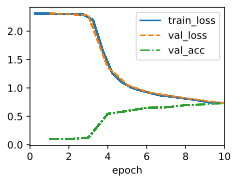

In [34]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

**8.2. Networks Using Blocks (VGG)**

In [35]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [36]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [37]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


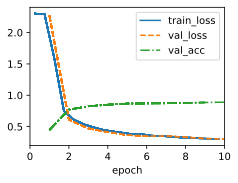

In [38]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

**8.2 key takeaways**


*   VGG Networks introduced the concept of using "blocks" of convolutional layers for building deep networks. These blocks typically consist of repeated convolutions followed by pooling, effectively capturing features at different scales.

*  VGG showed success with deep and narrow networks (many convolutional layers with fewer filters) compared to shallow and wide networks.


*   The text only shows details for 8 blocks, while VGG-11 has 11 layers.The remaining 3 layers are fully connected layers, which don't affect spatial dimensions. Their output size is independent of input size. The fully connected layers are responsible for processing the flattened output from the convolutional part and generating class probabilities.




**8.6. Residual Networks (ResNet) and ResNeXt**

In [39]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [40]:
class Residual(nn.Module):
    # The Residual block of ResNet models
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [41]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [42]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [43]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [44]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [45]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [46]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


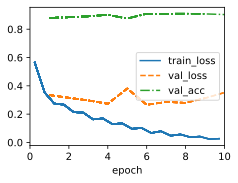

In [47]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

**8.6 key takeaways**

*   Deeper neural networks can be more expressive, but training them becomes harder. Adding layers doesn't guarantee better results. To ensure improvement with added layers, the new network architecture should encompass the capabilities of the previous one (think of them as nested sets).

*  Question: What is the difference between a regular block and a residual block?
answer: A regular block directly learns the desired mapping, while a residual block learns the difference between the desired mapping and the input (easier to learn).

*  Question: When is a 1x1 convolution used in a residual block?
Answer : It's used when we need to adjust the number of channels in the
input to match the output before adding them together.